## Installing Libraries

In [2]:
!pip install yfinance
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install joblib
!pip install seaborn
!pip install numpy
!pip install chart_studio
## https://github.com/Worlddatascience/DataScienceCohort/blob/master/6_How_to_Create_a_Candlestick_Chart_using_Python.ipynb
!pip install cufflinks
## Code to Install Backtrader
!pip install backtrader 
!pip install pandas_datareader

In [3]:
!pip install scikit-learn

In [4]:
! pip install keras
! pip install tensorflow

In [5]:
! pip install pmdarima

In [6]:
import warnings

warnings.filterwarnings('ignore')

import datetime
import yfinance

import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import seaborn as sns
import functools
from pandas.tseries.offsets import BDay

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix

import pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [7]:
name='QQQ'
frequency='1d'
first="2010-07-01"
last="2022-11-30"
ticker = yfinance.Ticker(name)
df = ticker.history(interval=frequency,start=first,end=last)

In [8]:
df.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-07-01 00:00:00-04:00,38.179932,38.286878,37.226325,37.957127,158695000,0.0,0
2010-07-02 00:00:00-04:00,38.019505,38.162100,37.511509,37.850174,78565300,0.0,0
2010-07-06 00:00:00-04:00,38.411641,38.652271,37.654104,37.966030,88591900,0.0,0
2010-07-07 00:00:00-04:00,38.090805,39.222653,38.055155,39.178093,72448400,0.0,0
2010-07-08 00:00:00-04:00,39.490033,39.552418,38.928563,39.391998,78264600,0.0,0


In [9]:
df1=df.loc[:, ["Close"]]

#df1=df1.rename(columns = {0:name},inplace=True)

In [10]:
# Resample the data weekly and monthly and do the same for the normalized data
stock_prices_daily=df.loc[:, ["Close"]]
#stock_prices_daily=pd
stock_prices_daily_normalized=df['Close'].div(df['Close'].max())
stock_prices_weekly = df['Close'].resample('W').mean()
stock_prices_weekly_normalized = stock_prices_daily_normalized.resample('W').mean()

stock_prices_monthly = df['Close'].resample('M').mean()
stock_prices_monthly_normalized = stock_prices_daily_normalized.resample('M').mean()

In [11]:
type(stock_prices_daily)

pandas.core.frame.DataFrame

In [12]:
## Calculate the returns for daily, weekly and monthly 

stock_returns_daily = stock_prices_daily.pct_change().dropna()

stock_returns_weekly = stock_prices_weekly.pct_change().dropna()

stock_returns_monthly = stock_prices_monthly.pct_change().dropna()

In [13]:
# Multi Period Return

def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

stock_returns_daily_pr = stock_returns_daily.rolling('360D').apply(multi_period_return)

In [14]:
stock_returns_daily_pr.head()

,Close
Date,
2010-07-02 00:00:00-04:00,-0.002818
2010-07-06 00:00:00-04:00,0.000235
2010-07-07 00:00:00-04:00,0.032167
2010-07-08 00:00:00-04:00,0.037802
2010-07-09 00:00:00-04:00,0.047664


In [15]:
# Define a function to use MaxMin Scaler for the modeling part

def scaler(train_array, test_array):
    scaler = MinMaxScaler(feature_range = (0,1))
    a = train_array.reshape(-1,1)
    b = test_array.reshape(-1,1)
    scaler = scaler.fit(a)
    X = scaler.transform(a)
    y = scaler.transform(b)
    return X, y

In [16]:
# Define a function to calculate the real price of the stock based on the MinMax Scaler

def scaler_inverse(train_array, predictions):
    scaler = MinMaxScaler(feature_range = (0,1))
    c = train_array.reshape(-1,1)
    scaler.fit(c)
    y_inverse = scaler.inverse_transform(predictions)
    return y_inverse

In [17]:
# Define a function to have the previous 5 days as independant features to predict the stock price

def preprocessing(dataset, time_steps = 1):
    X, y = [], []
    for i in range(len(dataset) - time_steps - 1):
        x = dataset[i:(i + time_steps), 0]
        X.append(x)
        y.append(dataset[i + time_steps, 0])
    return X, y

In [18]:
# Divide the train and test data
test_size = 60

train = df1[:-test_size]
test = df1[-test_size:]


In [19]:
# Define an empty array to change the shape of the X variable (train and test)
# The new shape with treat the stock prices as each of the subarrays
# Eight stocks mean an array with shape (8, n_days)

n_days = len(stock_prices_daily)

# Define number of stocks

n_stocks = len(stock_prices_daily.columns)

# Save the number of days that are going to be used as train and test

n_days_train = len(train)
n_days_test = len(test)

# Empty array for the train and test data

train_scale = np.zeros(shape = (n_stocks, n_days_train))

test_scale = np.zeros(shape = (n_stocks, n_days_test))

# Use the for loop to iterate over the train and test to have the array shape changed

for i in range(0, n_stocks):
    train_scale[i] = train.iloc[:,i]
    
for i in range(0, n_stocks):
    test_scale[i] = test.iloc[:,i]

In [20]:
# Empty arrays for the train and test data (n_stocks, ndays, 1) to make it usable after using the MinMax Scaler

Xtrain = np.empty(shape = (n_stocks, n_days_train, 1))

Xtest = np.empty(shape = (n_stocks, n_days_test, 1))

# For loop to create the Xtrain and Xtest and scale the data (by just fitting the train data). 
# The idea is to avoid the data leakage by scaling the complete data set

for i in range(n_stocks):
    Xtrain[i], Xtest[i] = scaler(train_array = train_scale[i], test_array = test_scale[i])

In [21]:
# Get together the Xtrain and Xtest to apply some feature engineering (Make previous 5 days as independent variables)
# and the day ahead the dependant variable

# Define the empty array to iterate over an array (more time efficient)

Values = np.empty(shape = (n_stocks, n_days, 1))

#Iterate by concatenating the Xtrain and Xtest

for i in range(n_stocks):
    Values[i] = np.concatenate((Xtrain[i], Xtest[i]))

In [22]:
# Use the function to use the previous 5 days as independent features for train data

time_steps = 5

# Make two empty list to store the data

X = []
y = []

for i in range(0, n_stocks):
    # Use the preprocessing function 
    a,b = preprocessing(dataset = Values[i], time_steps = time_steps)
    # Apend the values
    X.append(a)
    y.append(b)

# Make sure to have them as arrays

X = np.array(X)
y = np.array(y)

In [23]:
# X_train array will have new shape

# Define the new days for each subarray

n_days_train_resample = n_days_train - time_steps - 1

# Make empty arrays with the reshape of the data after taking the 5 days as independant variables

X_train = np.empty(shape = (n_stocks, n_days_train_resample, 5))

y_train = np.empty(shape = (n_stocks, n_days_train_resample))

X_test = np.empty(shape = (n_stocks, n_days_test, 5))

y_test = np.empty(shape = (n_stocks, n_days_test))

In [24]:
# Start for the X_train, y_train, X_test, y_test

for i in range(n_stocks):
    X_train[i], y_train[i] = X[i][:n_days_train_resample], y[i][:n_days_train_resample]
    X_test[i], y_test[i] = X[i][n_days_train_resample:], y[i][n_days_train_resample:]

In [25]:
# Reshape input to be [samples, time steps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , X_test.shape[2], 1)

In [26]:
print('Shape of the train data to use at the model', X_train.shape, y_train.shape)
print('Shape of the test data to use', X_test.shape, y_test.shape)

Shape of the train data to use at the model (1, 3060, 5, 1) (1, 3060)
Shape of the test data to use (1, 60, 5, 1) (1, 60)


In [27]:
# Define a model to build the neural network

def neural_network():
    # Begin with Sequential
    regressor = Sequential()
    # The first layer would the be LSTM
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (5,1)))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return regressor

In [28]:
# Define a variable to reshape the train and test data into shape (, , 1) to make it processable on the neural network

def variables_model(n):
    x_train, Y_train = X_train[n], y_train[n]
    x_test, Y_test = X_test[n], y_test[n]
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    
    return (x_train, x_test, Y_train, Y_test)
    

In [29]:
# Fit the model and get the predictions

def model_fit(Xtr, ytr, Xte):
    model.fit(Xtr, ytr, epochs = 50, batch_size = 32)
    pred = model.predict(Xte)
    return pred

In [30]:
# For future use in plotting, create one data frame to have the train values plus the test values
# and another pandas series to have the train data plus the predicted values

def df_merger(train_data, test_data, pred_values):
    actual_data = train_data.append(test_data)
    predicted_data = train_data.append(pred_values)
    return actual_data, predicted_data

In [31]:
# Compare actual values with predicted values with a plot

def plot_comparison(actual, predicted, string):
    #Visualizing the prediction
    plt.figure(figsize=(10,6))
    plt.plot(actual[:-test_size], color = 'blue')
    plt.plot(actual[-test_size:], color = 'orange', label = 'Actual Values')
    plt.plot(predicted[-test_size:], color = 'green', label = 'Predicted Values')
    plt.title(string)
    plt.xlabel('Trading Day')
    plt.ylabel('Price')
    plt.legend()
    return plt.show()
    

In [32]:
# Save a data frame to concat all the predictions

# Start with an empty data frame
predictions_df = pd.DataFrame()

# Start with the same date than the test for the comparisons.
predictions_df['Date'] = test.index

#Set the date as the index
predictions_df.set_index('Date', inplace = True)

In [33]:
# Define the model

model = neural_network()

In [34]:
# Check the summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [35]:
# Get the data for this stock

S_Xtrain, S_Xtest, S_ytrain, S_ytest = variables_model(n = 0)

In [36]:
# Fit the data for the stock

S_pred = model_fit(Xtr = S_Xtrain, ytr = S_ytrain, Xte = S_Xtest)


Train on 3060 samples
Epoch 1/50
3060/3060 [==============================] - 2s 605us/sample - loss: 0.0221
Epoch 2/50
3060/3060 [==============================] - 1s 351us/sample - loss: 0.0020
Epoch 3/50
3060/3060 [==============================] - 1s 390us/sample - loss: 0.0018
Epoch 4/50
3060/3060 [==============================] - 1s 263us/sample - loss: 0.0016
Epoch 5/50
3060/3060 [==============================] - 1s 224us/sample - loss: 0.0015
Epoch 6/50
3060/3060 [==============================] - 1s 220us/sample - loss: 0.0015
Epoch 7/50
3060/3060 [==============================] - 1s 260us/sample - loss: 0.0013
Epoch 8/50
3060/3060 [==============================] - 1s 296us/sample - loss: 0.0013
Epoch 9/50
3060/3060 [==============================] - 1s 235us/sample - loss: 0.0012
Epoch 10/50
3060/3060 [==============================] - 1s 235us/sample - loss: 0.0012
Epoch 11/50
3060/3060 [==============================] - 1s 285us/sample - loss: 0.0011
Epoch 12/50
3060/30

In [37]:
# Use the inverse transform function

S_pred_prices = scaler_inverse(train_array = train['Close'].values, predictions = S_pred)


In [38]:
# Add the first column to the data frame that will store the predictions

predictions_df['Close'] = S_pred_prices


In [39]:
# Get the actual and predicted data as data frames for both

QQQ_actual, QQQ_predicted = df_merger(train_data = train['Close'], test_data = test['Close'], 
                                  pred_values = predictions_df['Close'])


In [40]:
#QQQ_actual.info()
#df1.info()
QQQ_actual.tail()

Date
2022-11-22 00:00:00-05:00    285.950012
2022-11-23 00:00:00-05:00    288.820007
2022-11-25 00:00:00-05:00    286.920013
2022-11-28 00:00:00-05:00    282.709991
2022-11-29 00:00:00-05:00    280.570007
Name: Close, dtype: float64

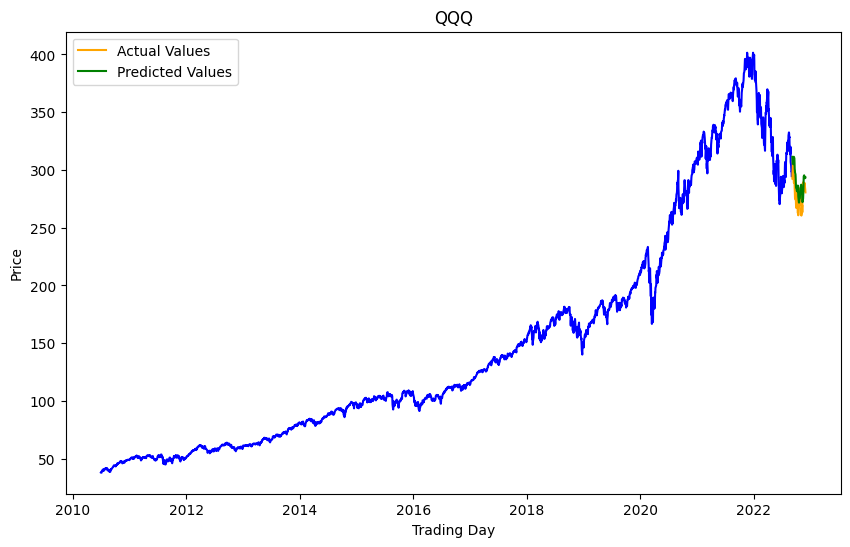

In [41]:
# Plot the S Stock Price comparison

plot_comparison(actual = QQQ_actual, predicted = QQQ_predicted, string = 'QQQ')

In [42]:
class model_reinforcement:
    
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
        
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [43]:
def plot_signals(values):
    fig = plt.figure(figsize = (15,5))
    plt.plot(values, color='r', lw=2.)
    plt.plot(values, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
    plt.plot(values, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
    plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
    plt.legend()
    plt.show()

In [44]:
initial_money = 1000
window_size = 5
skip = 1
batch_size = 32

In [45]:
# Define the values for the S Stock

close = QQQ_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 1.644165.3, cost: 0.046293, total money: 1001.644165
epoch: 20, total rewards: 0.654179.3, cost: 0.026674, total money: 1000.654179
epoch: 30, total rewards: 17.029522.3, cost: 0.023309, total money: 1017.029522
epoch: 40, total rewards: -29.671658.3, cost: 0.022208, total money: 970.328342
epoch: 50, total rewards: -27.479355.3, cost: 0.015945, total money: 972.520645
epoch: 60, total rewards: -16.865307.3, cost: 0.013110, total money: 983.134693
epoch: 70, total rewards: 0.728767.3, cost: 0.012896, total money: 1000.728767
epoch: 80, total rewards: -12.839600.3, cost: 0.010500, total money: 987.160400
epoch: 90, total rewards: -17.862526.3, cost: 0.020385, total money: 982.137474
epoch: 100, total rewards: -26.124531.3, cost: 0.008651, total money: 973.875469


In [46]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 490: buy 1 unit at price 55.937862, total balance 944.062138
day 491, sell 1 unit at price 56.616608, investment 1.213392 %, total balance 1000.678745,
day 589: buy 1 unit at price 59.919544, total balance 940.759201
day 592, sell 1 unit at price 59.783112, investment -0.227693 %, total balance 1000.542313,
day 1230: buy 1 unit at price 104.142059, total balance 896.400253
day 1233, sell 1 unit at price 104.499939, investment 0.343646 %, total balance 1000.900192,
day 1294: buy 1 unit at price 96.660095, total balance 904.240097
day 1295, sell 1 unit at price 92.940956, investment -3.847647 %, total balance 997.181053,
day 1358: buy 1 unit at price 108.325890, total balance 888.855164
day 1359, sell 1 unit at price 108.013618, investment -0.288270 %, total balance 996.868782,
day 1442: buy 1 unit at price 102.105972, total balance 894.762810
day 1443, sell 1 unit at price 101.963165, investment -0.139862 %, total balance 996.725975,
day 1507: buy 1 unit at price 97.567322, total ba

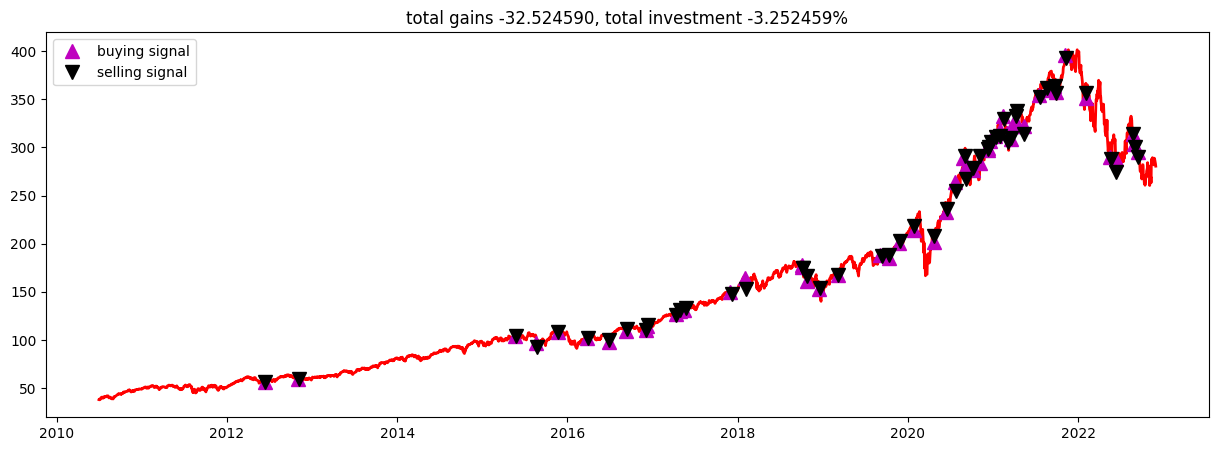

In [47]:
# Plot the results

plot_signals(values = QQQ_actual)

### For Predicted Values from Neural nETWORK

In [48]:
# Define the values for the S Stock

close = QQQ_predicted.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 245.482719.3, cost: 0.032373, total money: 1245.482719
epoch: 20, total rewards: 122.571846.3, cost: 0.017402, total money: 1122.571846
epoch: 30, total rewards: 3.248970.3, cost: 0.010784, total money: 1003.248970
epoch: 40, total rewards: 5.974888.3, cost: 0.009487, total money: 1005.974888
epoch: 50, total rewards: 56.162888.3, cost: 0.009471, total money: 1056.162888
epoch: 60, total rewards: 20.808273.3, cost: 0.008332, total money: 1020.808273
epoch: 70, total rewards: 18.430599.3, cost: 0.008040, total money: 1018.430599
epoch: 80, total rewards: -5.772949.3, cost: 0.018121, total money: 994.227051
epoch: 90, total rewards: 18.492599.3, cost: 0.006879, total money: 1018.492599
epoch: 100, total rewards: 6.496460.3, cost: 0.006253, total money: 1006.496460


In [49]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 293: buy 1 unit at price 49.059040, total balance 950.940960
day 295, sell 1 unit at price 49.463303, investment 0.824033 %, total balance 1000.404263,
day 685: buy 1 unit at price 62.886562, total balance 937.517700
day 686, sell 1 unit at price 62.657356, investment -0.364475 %, total balance 1000.175056,
day 918: buy 1 unit at price 83.576469, total balance 916.598587
day 919, sell 1 unit at price 83.502441, investment -0.088575 %, total balance 1000.101028,
day 1145: buy 1 unit at price 95.484116, total balance 904.616913
day 1146: buy 1 unit at price 95.972694, total balance 808.644218
day 1148, sell 1 unit at price 97.964684, investment 2.597885 %, total balance 906.608902,
day 1149, sell 1 unit at price 97.851952, investment 1.958117 %, total balance 1004.460854,
day 1208: buy 1 unit at price 101.768745, total balance 902.692108
day 1209, sell 1 unit at price 102.324417, investment 0.546014 %, total balance 1005.016525,
day 1269: buy 1 unit at price 107.222855, total balance

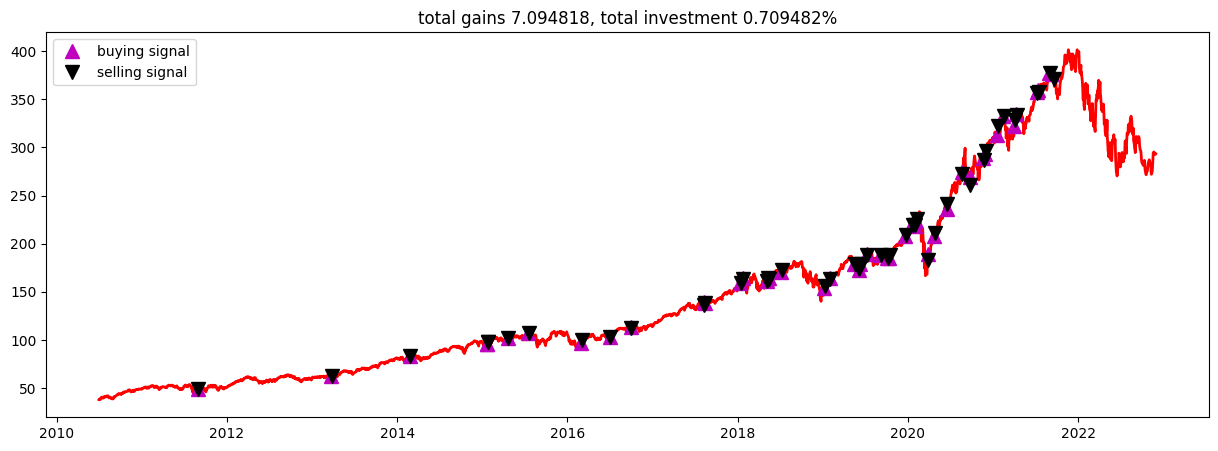

In [50]:
# Plot the results

plot_signals(values = QQQ_predicted)